## All Qualifying Session Analysis

Using the data gathered in the previous file, I will conduct an analysis for all qualifying sessions & drivers in the 2021 season.

The data contains the fastest lap for each driver in each qualifying session in the 2021 season. This data comes from the fastf1 package, which is the best (and only!) publicly-available source I have found that captures granular data on Formula 1 races.

One caveat with this data is that any lap times that are deleted from the official results (in cases where a driver exceeds track limits over the course of a lap) are still included in this dataset. This means the results here may not exactly square with official results, but they should be very close and the presence of these deleted laptimes won't affect my analysis much.

The first thing we should do is load all the packages we know we will need and load the raw data that is saved down to my computer.

In [30]:
#Setting up - import packages
import pandas as pd
import numpy as np
import fastf1 as ff1
#Enable the cache
ff1.Cache.enable_cache('C:/Users/jackh/OneDrive/Documents/Python Scripts/f1_cache') 

In [31]:
#Load existing data - saved as .csv file
raw = pd.read_csv('C:/Users/jackh/OneDrive/Documents/Python Scripts/2021_f1_qualifying_laps.csv')

In [32]:
raw.head()

,Unnamed: 0,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,...,Source,RelativeDistance,Status,X,Y,Z,Distance,Driver,GP,Location
0,0,2021-03-27 15:59:07.466,0 days 01:14:07.081000,NaN,715.495556,0 days 00:00:00,10531,295,8,100,...,interpolation,0.000016,OnTrack,-384,1200,-159,0.000000,VER,1,Bahrain
1,1,2021-03-27 15:59:07.603,0 days 01:14:07.218000,NaN,715.495556,0 days 00:00:00.137000,10537,296,8,100,...,pos,0.002104,OnTrack,-378,1312,-159,11.264444,VER,1,Bahrain
2,2,2021-03-27 15:59:07.635,0 days 01:14:07.250000,NaN,715.495556,0 days 00:00:00.169000,10549,297,8,100,...,car,0.002592,OnTrack,-376,1338,-159,13.904444,VER,1,Bahrain
3,3,2021-03-27 15:59:07.823,0 days 01:14:07.438000,NaN,715.495556,0 days 00:00:00.357000,10635,297,8,100,...,pos,0.005465,OnTrack,-369,1493,-159,29.414444,VER,1,Bahrain
4,4,2021-03-27 15:59:07.875,0 days 01:14:07.490000,44.0,715.495556,0 days 00:00:00.409000,10721,298,8,100,...,car,0.006262,OnTrack,-367,1536,-158,33.718889,VER,1,Bahrain


### I: Breaking Down Tracks into Minisectors

Before we analyze each driver's qualifying performance across the 2021 season, we must break each track into minisectors because telemetry data does not exactly line up at each point for each driver. By grouping each lap into minisectors we can analyze each teammate's performance on the same granularity. I'll break each circuit into 25 minisectors and assign each captured telemetry reading to a minisector based on the 'Distance' field, which tells us how many meters along the lap each driver is.

In [33]:
#Define number of minisectors
num_minisectors = 25.0
#Find the max distance for each gp
distance_gp = raw.groupby('GP')['Distance'].max().reset_index().rename(columns = {"Distance":"max_distance"})
#And attach to main df
df = raw.merge(distance_gp, how = 'inner', on = 'GP')

In [34]:
#Now calculate the minisector for each point in the data
df['Minisector'] = (df['Distance'] // (df['max_distance']/num_minisectors + .01) ) + 1

#And convert minisector to integer type - must do this in a second step
df['Minisector'] = df['Minisector'].astype(int)

### II: Assigning each driver an average speed per track & minisector

Because the telemetry isn't captured at exactly the same spot for each driver, a good way to break down performance is to capture average speed per minisector.

But first, I'll rank each driver based on their overall performance in each session. This way, I will make sure that for each team, the faster driver has a positive speed differential to his teammate in a given session.

In [35]:
#First - create an object that ranks overall speed of each driver, so that we ensure each team's faster driver is the one that comes out ahead vs. his teammate (ie the gap in speed is always positive for the faster driver)
r = df[["Location", "Driver", "Speed"]]
r = r.groupby(['Location', 'Driver'])['Speed'].mean().reset_index()
r['rank'] = r.groupby('Location')['Speed'].rank(ascending = False)
r = r.drop('Speed', axis = 1)

In [36]:
#And merge into the dataframe
df = df.merge(r, how = 'left', on = ['Location', 'Driver'])

In [37]:
#Add team information to dataset
driver_team = pd.DataFrame({'Driver':['VER', 'PER', 'HAM', 'BOT', 'LEC', 'SAI', 'RIC', 'NOR', 'ALO', 'OCO'
                                      , 'VET', 'STR', 'GAS', 'TSU', 'RUS', 'LAT', 'RAI', 'GIO', 'MSC', 'MAZ'],
                            'Team': ['Red Bull', 'Red Bull', 'Mercedes', 'Mercedes', 'Ferrari', 'Ferrari', 'McLaren', 'McLaren', 'Alpine', 'Alpine'
                                     , 'Aston Martin', 'Aston Martin', 'Alpha Tauri', 'Alpha Tauri', 'Williams', 'Williams', 'Alfa Romeo' , 'Alfa Romeo', 'Haas', 'Haas']})

df = df.merge(driver_team, how = 'left', on = 'Driver')

In [38]:
#Calculate each driver's minisector speed for each session, an arrange the results based on overall rank in the session
average_speed = df.groupby(['GP', 'Location', 'Minisector', 'Team', 'Driver', 'rank'])['Speed'].mean().reset_index().sort_values(by=['GP', 'Team', 'Minisector', 'rank'], ascending = (True))

### Assign each minisector a speed category
Based on the average speed through that minisector, each minisector at each track can be assigned 'low', 'medium', or 'high' speeds.

In [39]:
#Determine what the cutoff is for a 'low speed' and 'high speed' minisector is for each track
sector_speed = df.groupby(['Location', 'Minisector'])['Speed'].mean().reset_index()
low_speeds = sector_speed.groupby('Location')['Speed'].quantile(q=.33).rename('low_speed_threshold').reset_index()
high_speeds = sector_speed.groupby('Location')['Speed'].quantile(q=.66).rename('high_speed_threshold').reset_index()

speed_key = low_speeds.merge(high_speeds, how = 'inner', on = 'Location')


In [40]:
#Now we can compare the thresholds to the average speeds each driver maintained in each minisector
#To do this, we'll come up with a grid-wide average speed indicator, similar to the average_speed table above
field_average_speed = df.groupby(['Location', 'Minisector'])['Speed'].mean().reset_index().sort_values(by=['Location', 'Minisector'], ascending = (True))

#And apply the speed_key object to this table
field_average_speed = field_average_speed.merge(speed_key, how = 'left', on = 'Location')


In [41]:
#Now we can assign each track's minisector a high, medium, or low value
field_average_speed['Sector_speed'] = np.where(field_average_speed['Speed'].lt(field_average_speed['low_speed_threshold']), 'Low',np.where(field_average_speed['Speed'].lt(field_average_speed['high_speed_threshold']),'Medium', 'High'))
#And drop the extra columns
field_average_speed = field_average_speed.drop(columns=['Speed', 'low_speed_threshold', 'high_speed_threshold'])

In [42]:
#And join it to the main data frame
average_speed = average_speed.merge(field_average_speed, how = 'left', on = ['Location', 'Minisector'])

Finally, we can calculate each driver's pace gap to his teammate by track. This is important because in F1, each team's car performs slightly differently. We expect that a 'powerhouse' like Mercedes will always beat a driver in a slower car such as Williams... but that doesn't necessarily mean that Mercedes driver Valtteri Bottas is inherently a better performer than Williams driver George Russell. By keeping comparisons within a team, we compare each driver to the only other driver that faces exactly the same set of challenges they do: their teammate.

In [43]:
#This calculates the faster driver's gap to their teammate
gap_faster = average_speed.groupby(['GP', 'Location', 'Team', 'Minisector'])['Speed'].apply(pd.Series.pct_change).to_frame().rename(columns={"Speed":"gap_faster"})
#And join back to the main data frame (test form)
average_speed = pd.concat([average_speed, gap_faster], axis = 1)

In [44]:
#This calculates the slower driver's gap to their teammate
average_speed_slower = average_speed.sort_values(by=['GP', 'Team', 'Minisector', 'rank'], ascending = (True, True, True, False))
gap_slower = average_speed_slower.groupby(['GP', 'Location', 'Team', 'Minisector'])['Speed'].apply(pd.Series.pct_change).to_frame().rename(columns={"Speed":"gap_slower"})
#And join back to the main data frame (test form)
average_speed = pd.concat([average_speed, gap_slower], axis = 1)

In [45]:
#And merge these two fields into one
average_speed['speed_gap'] = np.where(average_speed['gap_faster'].isnull(),average_speed['gap_slower'], average_speed['gap_faster'])
average_speed = average_speed.drop(columns = ['gap_faster', 'gap_slower'])

Finally, we can do a little cleanup - remove those minisectors where the average gap is 'NA' (cases where one teammate did not set any times) or extremely large (likely happening mid-crash where a driver registers speed but it is extremely low)

In [46]:
#First - drop NA values
average_speed = average_speed.dropna(subset = ['speed_gap'])

#Second - eliminate any instances where the speed gap is > 50%... these are outliers.
average_speed = average_speed.loc[(average_speed['speed_gap'] < .5) & (average_speed['speed_gap'] > -.5)]

### III: Analysis

The first question I will attempt to answer is, which driver beats his teammate the most in low-speed corners?

In [47]:
low_speeds = average_speed[average_speed['Sector_speed']=='Low'].groupby(['Team', 'Driver'])['speed_gap'].mean().reset_index()

And we can plot this difference

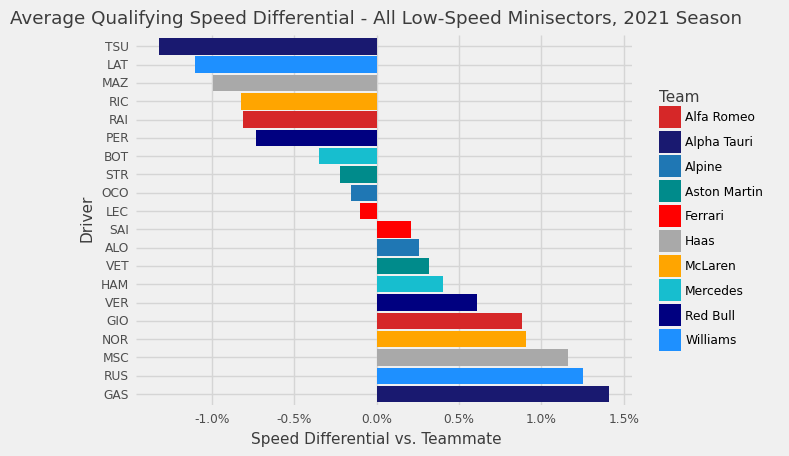

In [48]:
from plotnine import ggplot, aes, geom_col, theme_538, scale_fill_manual, labs, ggtitle, guides, scale_y_continuous, scale_color_manual, scale_fill_manual, coord_flip
from mizani.formatters import custom_format
#First - define a team palette
team_palette = {'Alfa Romeo':'tab:red', 'Alpha Tauri':'midnightblue', 'Alpine':'tab:blue', 'Aston Martin':'darkcyan', 'Ferrari':'red'
                , 'Haas': 'darkgrey', 'McLaren': 'orange', 'Mercedes':'tab:cyan', 'Red Bull':'navy', 'Williams':'dodgerblue'}
team_palette = pd.DataFrame.from_dict(team_palette, orient='index').reset_index()
team_palette.rename(columns={"index":"Team", 0:"Color"})

colors = team_palette[0].tolist()

#And we can do a little more cleanup for graphing
low_speeds['speed_gap_pct'] = low_speeds['speed_gap']*100

driver_list = low_speeds.sort_values(by = 'speed_gap', ascending = False)['Driver'].tolist()
driver_cat = pd.Categorical(low_speeds['Driver'], categories = driver_list)


a = (ggplot(low_speeds, aes(x="driver_cat", y = "speed_gap_pct", fill = "Team"))
     + geom_col()
     + theme_538()
     + labs(x='Driver', y = 'Speed Differential vs. Teammate')
     + ggtitle("Average Qualifying Speed Differential - All Low-Speed Minisectors, 2021 Season")
     + guides(color = False, size = False)
     + scale_y_continuous(labels=custom_format('{:.1f}%'))
     + coord_flip()
     + scale_fill_manual(values = colors)
)

print(a)

And we can repeat for medium-speed corners...

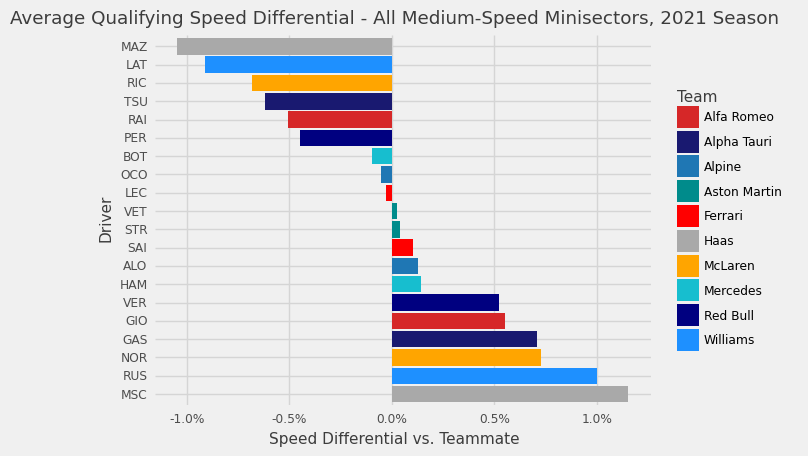

In [49]:
#Create dataset
med_speeds = average_speed[average_speed['Sector_speed']=='Medium'].groupby(['Team', 'Driver'])['speed_gap'].mean().reset_index()

#And graph
med_speeds['speed_gap_pct'] = med_speeds['speed_gap']*100

driver_list = med_speeds.sort_values(by = 'speed_gap', ascending = False)['Driver'].tolist()
driver_cat = pd.Categorical(med_speeds['Driver'], categories = driver_list)


b = (ggplot(med_speeds, aes(x="driver_cat", y = "speed_gap_pct", fill = "Team"))
     + geom_col()
     + theme_538()
     + labs(x='Driver', y = 'Speed Differential vs. Teammate')
     + ggtitle("Average Qualifying Speed Differential - All Medium-Speed Minisectors, 2021 Season")
     + guides(color = False, size = False)
     + scale_y_continuous(labels=custom_format('{:.1f}%'))
     + coord_flip()
     + scale_fill_manual(values = colors)
)

print(b)

...and finally for high speed minisectors

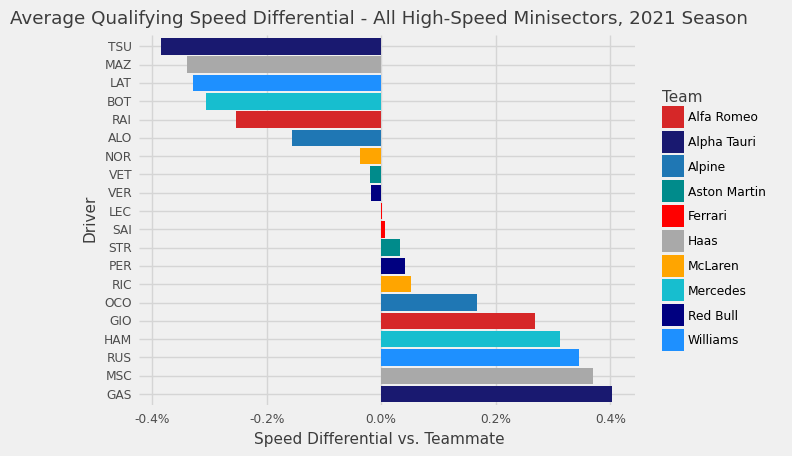

In [50]:
#Create dataset
high_speeds = average_speed[average_speed['Sector_speed']=='High'].groupby(['Team', 'Driver'])['speed_gap'].mean().reset_index()

#And graph
high_speeds['speed_gap_pct'] = high_speeds['speed_gap']*100

driver_list = high_speeds.sort_values(by = 'speed_gap', ascending = False)['Driver'].tolist()
driver_cat = pd.Categorical(high_speeds['Driver'], categories = driver_list)


c = (ggplot(high_speeds, aes(x="driver_cat", y = "speed_gap_pct", fill = "Team"))
     + geom_col()
     + theme_538()
     + labs(x='Driver', y = 'Speed Differential vs. Teammate')
     + ggtitle("Average Qualifying Speed Differential - All High-Speed Minisectors, 2021 Season")
     + guides(color = False, size = False)
     + scale_y_continuous(labels=custom_format('{:.1f}%'))
     + coord_flip()
     + scale_fill_manual(values = colors)
)

print(c)

All together now in one graph!

First, we have to analyze each driver's speed in each minisector type and compare to their teammate, just as in the prior section.

In [54]:
#First we need to create the proper dataset - each driver's average speed for each minisector type
driver_type_speed = average_speed.groupby(['Driver', 'Team', 'Sector_speed'])['Speed'].mean().reset_index().sort_values(by = ['Team', 'Speed'], ascending=(True, False))#.apply(pd.Series.pct_change)['Speed'].to_frame()

#This calculates the faster driver's gap to their teammate in each sector type
gap_faster = driver_type_speed.groupby(['Team', 'Sector_speed'])['Speed'].apply(pd.Series.pct_change).to_frame().rename(columns={"Speed":"gap_faster"})
#And join back to the main data frame (test form)
driver_type_speed = pd.concat([driver_type_speed, gap_faster], axis = 1)

#This calculates the slower driver's gap to their teammate in each sector type
gap_slower = driver_type_speed.sort_values(by = ['Team', 'Speed'], ascending = True).groupby(['Team', 'Sector_speed'])['Speed'].apply(pd.Series.pct_change).to_frame().rename(columns={"Speed":"gap_slower"})
#And join back to the main data frame (test form)
driver_type_speed = pd.concat([driver_type_speed, gap_slower], axis = 1)

#Finally, reduce unnecessary columns
driver_type_speed['speed_gap'] = np.where(driver_type_speed['gap_faster'].isnull(),driver_type_speed['gap_slower'], driver_type_speed['gap_faster'])
driver_type_speed = driver_type_speed.drop(columns = ['gap_faster', 'gap_slower'])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Driver        60 non-null     object 
 1   Team          60 non-null     object 
 2   Sector_speed  60 non-null     object 
 3   Speed         60 non-null     float64
 4   speed_gap     60 non-null     float64
dtypes: float64(2), object(3)
memory usage: 2.8+ KB


And now we can graph it.

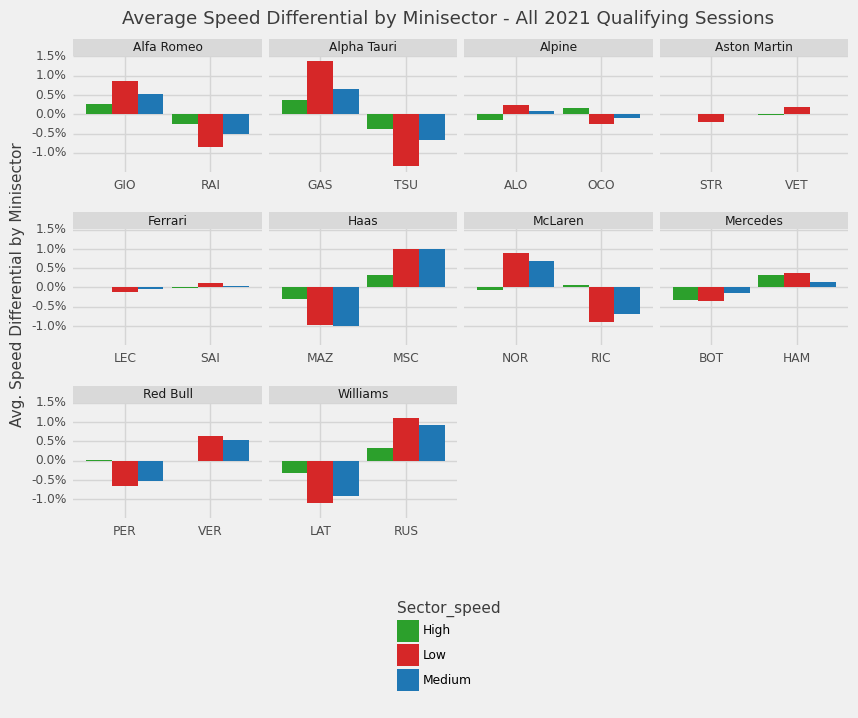

In [83]:
from plotnine import theme, facet_wrap, element_line
#Create table - one row per session

driver_type_speed['speed_gap_pct'] = driver_type_speed['speed_gap'] * 100

d = (
    ggplot(driver_type_speed, aes(x = 'Driver', y = 'speed_gap_pct', fill = 'Sector_speed'))
    + geom_col(position = 'dodge')
    + theme_538()
    + labs(x = '', y = 'Avg. Speed Differential by Minisector')
    + ggtitle('Average Speed Differential by Minisector - All 2021 Qualifying Sessions')
    + guides(color = False, size = False)
    + scale_y_continuous(labels=custom_format('{:.1f}%'))
    + theme(legend_position = (.5, -.1), figure_size = (10,6), subplots_adjust= {'hspace':0.5})
    +scale_fill_manual(values= ['tab:green', 'tab:red', 'tab:blue'])
    + facet_wrap('~Team', scales = 'free_x')
)

print(d)